<a href="https://colab.research.google.com/github/trustyuke/BE562_Project/blob/main/TMB_Survival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the data from github 
It contains the data downloaded from https://www.cbioportal.org/study/summary?id=tmb_mskcc_2018. It is genomic and survival data from 1661 tumor-normal pairs from 1661 patients with various cancer types sequenced with the MSK-IMPACT assay.

In [16]:
!git clone https://github.com/trustyuke/BE562_Project


fatal: destination path 'BE562_Project' already exists and is not an empty directory.


In [17]:
# import torch
# import torchvision
# from torchvision import transforms, datasets
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import TensorDataset
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#MLP classifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# MLP regression
from sklearn.neural_network import MLPRegressor

from sklearn import metrics

import seaborn as sns



# Load and Clean the Clinical dataset 


In [18]:
# Load the dataset
Clinical = pd.read_csv("BE562_Project/clinical_data.csv")
# Find number of missing value for each column 
Clinical.isna().sum()
# Realized Metastatic_Site has 760 columns and so we decided not to consider this feature and thus delete it
Clinical = Clinical.drop(['Metastatic_Site'], axis=1)
# Mutation_Count has 51 NA and Tumor_Purity has 29 NA and 35 default. Due to our large datasize (1681 data), we decided to drop column with missing value 
Clinical = Clinical.dropna()
Clinical = Clinical[Clinical.Tumor_Purity != "default"]

In [19]:
# Convert Survival_Status to a binary variable with 0 representing deceased and 1 representing living 
def convert_status(row):
  if row.Survival_Status == '1:DECEASED':
    return 1
  else:
    return 0 
Clinical['Survival_Status_0_1'] = Clinical.apply(convert_status, axis='columns')
def convert_Gender(row):
  if row.Sex == "Male":
    return 0
  elif row.Sex == "Female":
    return 1 

Clinical['Gender_binary'] = Clinical.apply(convert_Gender, axis='columns')
Clinical['Tumor_Purity'] = Clinical['Tumor_Purity'].astype('float64')
Clinical

,ID,Age_Days_Sequencing,Age_Diagnosis_Years,Cancer_Type,Drug_Type,Mutation_Count,Survival_Month,Survival_Status,Primary_Tumor_Site,Sample_coverage,Sample_Type,Sex,Somatic_Status,TMB,Tumor_Purity,Survival_Status_0_1,Gender_binary
0,P-0000057,41.0,31-50,Breast Cancer,PD-1/PDL-1,5.0,0,1:DECEASED,Breast,835,Primary,Female,Matched,5.545777,25.0,1,1
1,P-0000062,80.0,>71,Esophagogastric Cancer,PD-1/PDL-1,6.0,1,1:DECEASED,Esophagus,1176,Primary,Male,Matched,6.654932,30.0,1,0
2,P-0000063,62.0,61-70,Bladder Cancer,PD-1/PDL-1,13.0,42,0:LIVING,Bladder,900,Primary,Male,Matched,15.528174,70.0,0,0
3,P-0000071,66.0,61-70,Bladder Cancer,PD-1/PDL-1,10.0,43,0:LIVING,Bladder,795,Primary,Male,Matched,9.982398,30.0,0,0
5,P-0000088,63.0,61-70,Bladder Cancer,PD-1/PDL-1,12.0,12,1:DECEASED,Bladder,783,Metastasis,Male,Matched,12.200708,60.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1656,P-0026892,89.0,>71,Bladder Cancer,PD-1/PDL-1,7.0,3,0:LIVING,Bladder,450,Metastasis,Male,Matched,6.052887,20.0,0,0
1657,P-0026970,62.0,61-70,Bladder Cancer,PD-1/PDL-1,30.0,4,0:LIVING,Bladder,676,Metastasis,Male,Matched,25.940943,40.0,0,0
1658,P-0027031,32.0,31-50,Esophagogastric Cancer,PD-1/PDL-1,3.0,5,0:LIVING,Stomach,413,Metastasis,Female,Matched,2.594094,30.0,0,1
1659,P-0027041,68.0,61-70,Cancer of Unknown Primary,PD-1/PDL-1,7.0,41,0:LIVING,Unknown,931,Metastasis,Female,Matched,6.052887,10.0,0,1


# Exploratory Data Analysis (EDA)

### __Examine how well TMB performs in predicting clinical response to ICI treatments on various types of cancer__
Past findings have suggested that tumor mutation burden (TMB) could serve as a biomarker to predict the response to ICI treatment in many cancer types. However, it may be a more accurate predictor for certain cancers and less for others. Thus, the project’s first goal is to determine which cancers with elevated TMB respond best to immunotherapy.

####__Examine Correlation between TMB and survival rate to see if TMB could serve as a biomarker in general__
(using binary variable survival_status encoded with 0 and 1, and continuous variable overal survival in months)

In [20]:
# Conduct Point-biserial Correlation to measure the relationship between a binary variable, Survival_Status, and a continuous variable, TMB 
import scipy.stats as stats
print(stats.pointbiserialr(Clinical.Survival_Status_0_1,Clinical.TMB))
# We found a negative correlation of -0.16 and a p_value < 0.05. Since we coded the survive as 0 and deceased as 1, this indicates that TMB tends to be higher for living. 
# This confirms the finding that cancer patients with high TMB are more suitable for ICI treatment. 

# Conduct Pearson correlation to measure the realtionship bettwen overall survival in month and TMB 
print(stats.pearsonr(Clinical.Survival_Month, Clinical.TMB))
# A Pearson correlation coefficient of 0.1035 and p value <0.05 also indicates that higher TMB tends to survive longer. Overall survival is from the first dose of ICI.


PointbiserialrResult(correlation=-0.16145271633044653, pvalue=1.714081232718441e-10)
(0.10592673689804724, 3.001765874828605e-05)


####__Select Cancer types examine (has at least 100 samples)__

In [21]:
#Clinical.Survival_Status.value_counts()

Cancer_type = Clinical.Cancer_Type.value_counts()
print(Cancer_type[:10])
Cancer_type_100 = Cancer_type[:8].index.tolist()
Cancer_type_100
# x, y = kaplan_meier_estimator(event, time)
# >>> plt.step(x, y, where="post")
# >>> plt.ylim(0, 1)
# >>> plt.show()


Non-Small Cell Lung Cancer    321
Melanoma                      297
Bladder Cancer                203
Renal Cell Carcinoma          141
Head and Neck Cancer          126
Esophagogastric Cancer        116
Glioma                        112
Colorectal Cancer             106
Cancer of Unknown Primary      82
Breast Cancer                  41
Name: Cancer_Type, dtype: int64


['Non-Small Cell Lung Cancer',
 'Melanoma',
 'Bladder Cancer',
 'Renal Cell Carcinoma',
 'Head and Neck Cancer',
 'Esophagogastric Cancer',
 'Glioma',
 'Colorectal Cancer']

__Plot Kaplan - Meier curve to understasnd survival probability over time__

Kaplan-Meier survival curves are a way of graphically displaying the time until study participants developed aarticular event or endpoint, often death. 
Because all participants started the study at a different time-point, each participant will have been followed for a different length of time. Many participants may not have yet had the ‘event’, so their outcome will be
unknown. A Kaplan-Meier curve displays both those participants who have had the event, and the duration onstudy of those who have not yet had the event.

The x-axis shows time, and the y-axis shows the proportion of patients who have or have not had the event. 

In [22]:
!pip install lifelines
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import pairwise_logrank_test

# import seaborn as sns
# import statistics
# from sklearn.impute import SimpleImputer
# from lifelines import KaplanMeierFitter, CoxPHFitter
# from lifelines.statistics import logrank_test
# from scipy import stats
#from sksurv.nonparametric import kaplan_meier_estimator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


####__Kaplan - Meier Curve for all cancer types__

,,test_statistic,p,-log2(p)
0,1,52.512475,4.275239e-13,41.08906


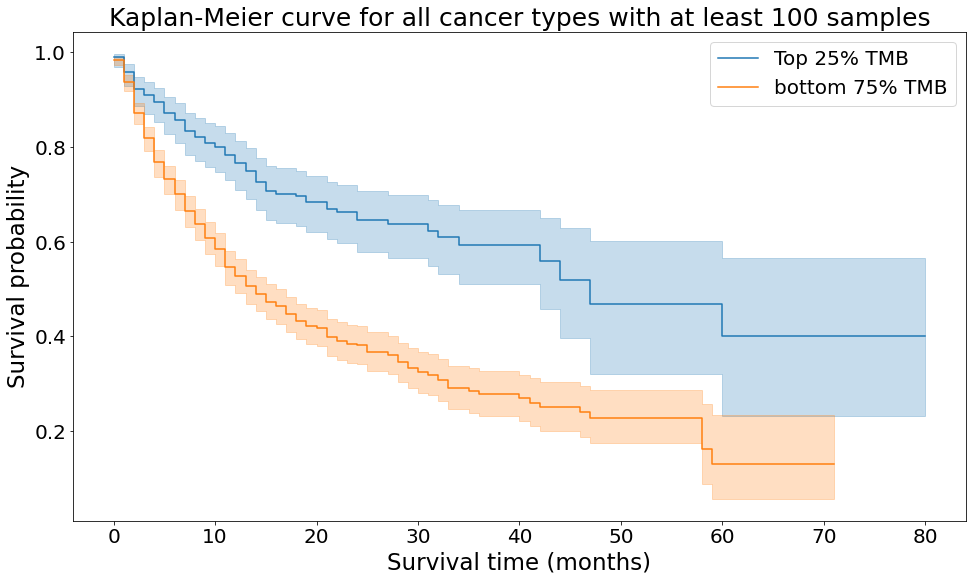

In [37]:
TMB_Survival = Clinical[["TMB","Cancer_Type","Survival_Status_0_1","Survival_Month"]]
TMB_Survival = TMB_Survival[Clinical["Cancer_Type"].isin(Cancer_type_100)]

def Convert_TMB_Status(row):
  if row.TMB >= TMB_Survival.TMB.describe()['75%']:
    return 1
  else:
    return 0

TMB_Survival["TMB_Status"] = TMB_Survival.apply(Convert_TMB_Status, axis='columns')
TMB_highest25_cutoff = TMB_Survival.TMB.describe()['75%']
TMB_Survival_top25 = TMB_Survival[TMB_Survival['TMB']>TMB_highest25_cutoff]
TMB_Survival_bottom75 = TMB_Survival[TMB_Survival['TMB']<TMB_highest25_cutoff]

## Kaplan-Meier curve, a popular survival analysis tool, is useful in understanding survival probability over time

plt.figure(figsize=(16,9))

top25 = KaplanMeierFitter() 
top25.fit(TMB_Survival_top25.Survival_Month, TMB_Survival_top25.Survival_Status_0_1, label = 'Top 25% TMB')
top25.plot()

bottom75 = KaplanMeierFitter() 
bottom75.fit(TMB_Survival_bottom75.Survival_Month, TMB_Survival_bottom75.Survival_Status_0_1, label = 'bottom 75% TMB')
bottom75.plot()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Kaplan-Meier curve for all cancer types with at least 100 samples", fontsize=25)
plt.xlabel("Survival time (months)", fontsize=23)
plt.ylabel("Survival probability", fontsize=23)
plt.legend()
plt.rc('legend', fontsize=20)

# top25.survival_function_
# top25.event_table

#print(bottom75.survival_function_)
#bottom75.event_table

log_rank = pairwise_logrank_test(TMB_Survival.Survival_Month, TMB_Survival["TMB_Status"], TMB_Survival.Survival_Status_0_1)
log_rank.summary



####__Kaplan - Kaier Curve for 8 cancer types__


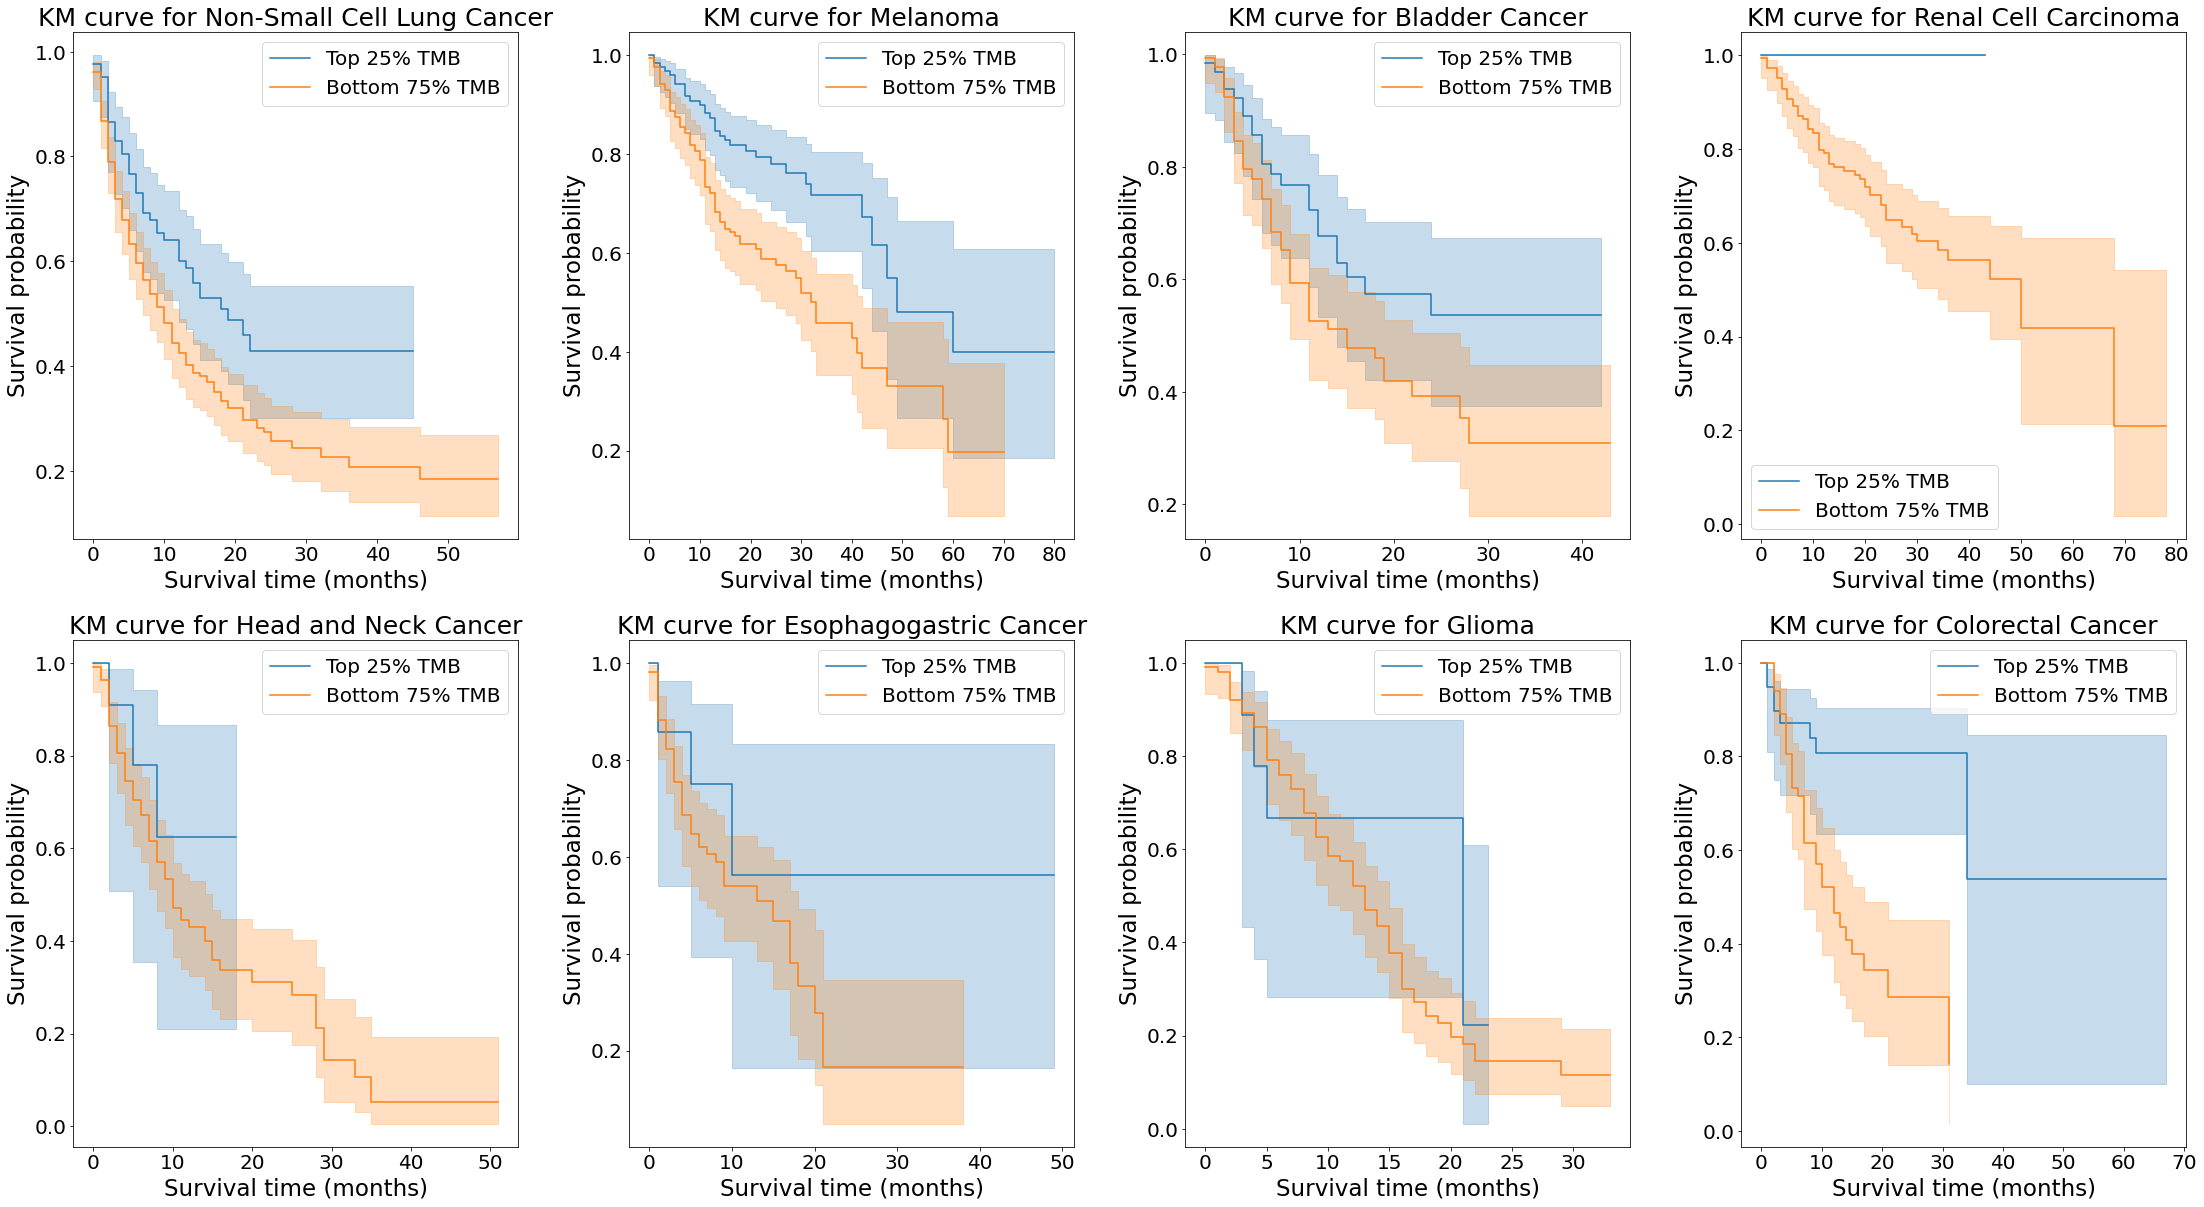

In [24]:
plt.subplots(2, 4, figsize=(32, 18))
plt.tight_layout(pad=8)

count = 0 
for i in Cancer_type_100:
  plt.subplot(241+count)
  top25 = KaplanMeierFitter() 
  TMB_Survival["TMB_Status"] = TMB_Survival.apply(Convert_TMB_Status, axis='columns')

  TMB_type_25 = TMB_Survival_top25[TMB_Survival_top25['Cancer_Type'] == i]
  top25.fit(TMB_type_25.Survival_Month, TMB_type_25.Survival_Status_0_1, label = 'Top 25% TMB')
  top25.plot()
  TMB_type_75 = TMB_Survival_bottom75[TMB_Survival_bottom75['Cancer_Type'] == i]
  top75 = KaplanMeierFitter() 
  top75.fit(TMB_type_75.Survival_Month, TMB_type_75.Survival_Status_0_1, label = 'Bottom 75% TMB')
  top75.plot()
  plt.xlabel("Survival time (months)", fontsize=23)
  plt.ylabel("Survival probability", fontsize=23)
  plt.title("KM curve for " + i, fontsize=25)
  plt.rc('legend', fontsize=20) 
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  count = count + 1
  

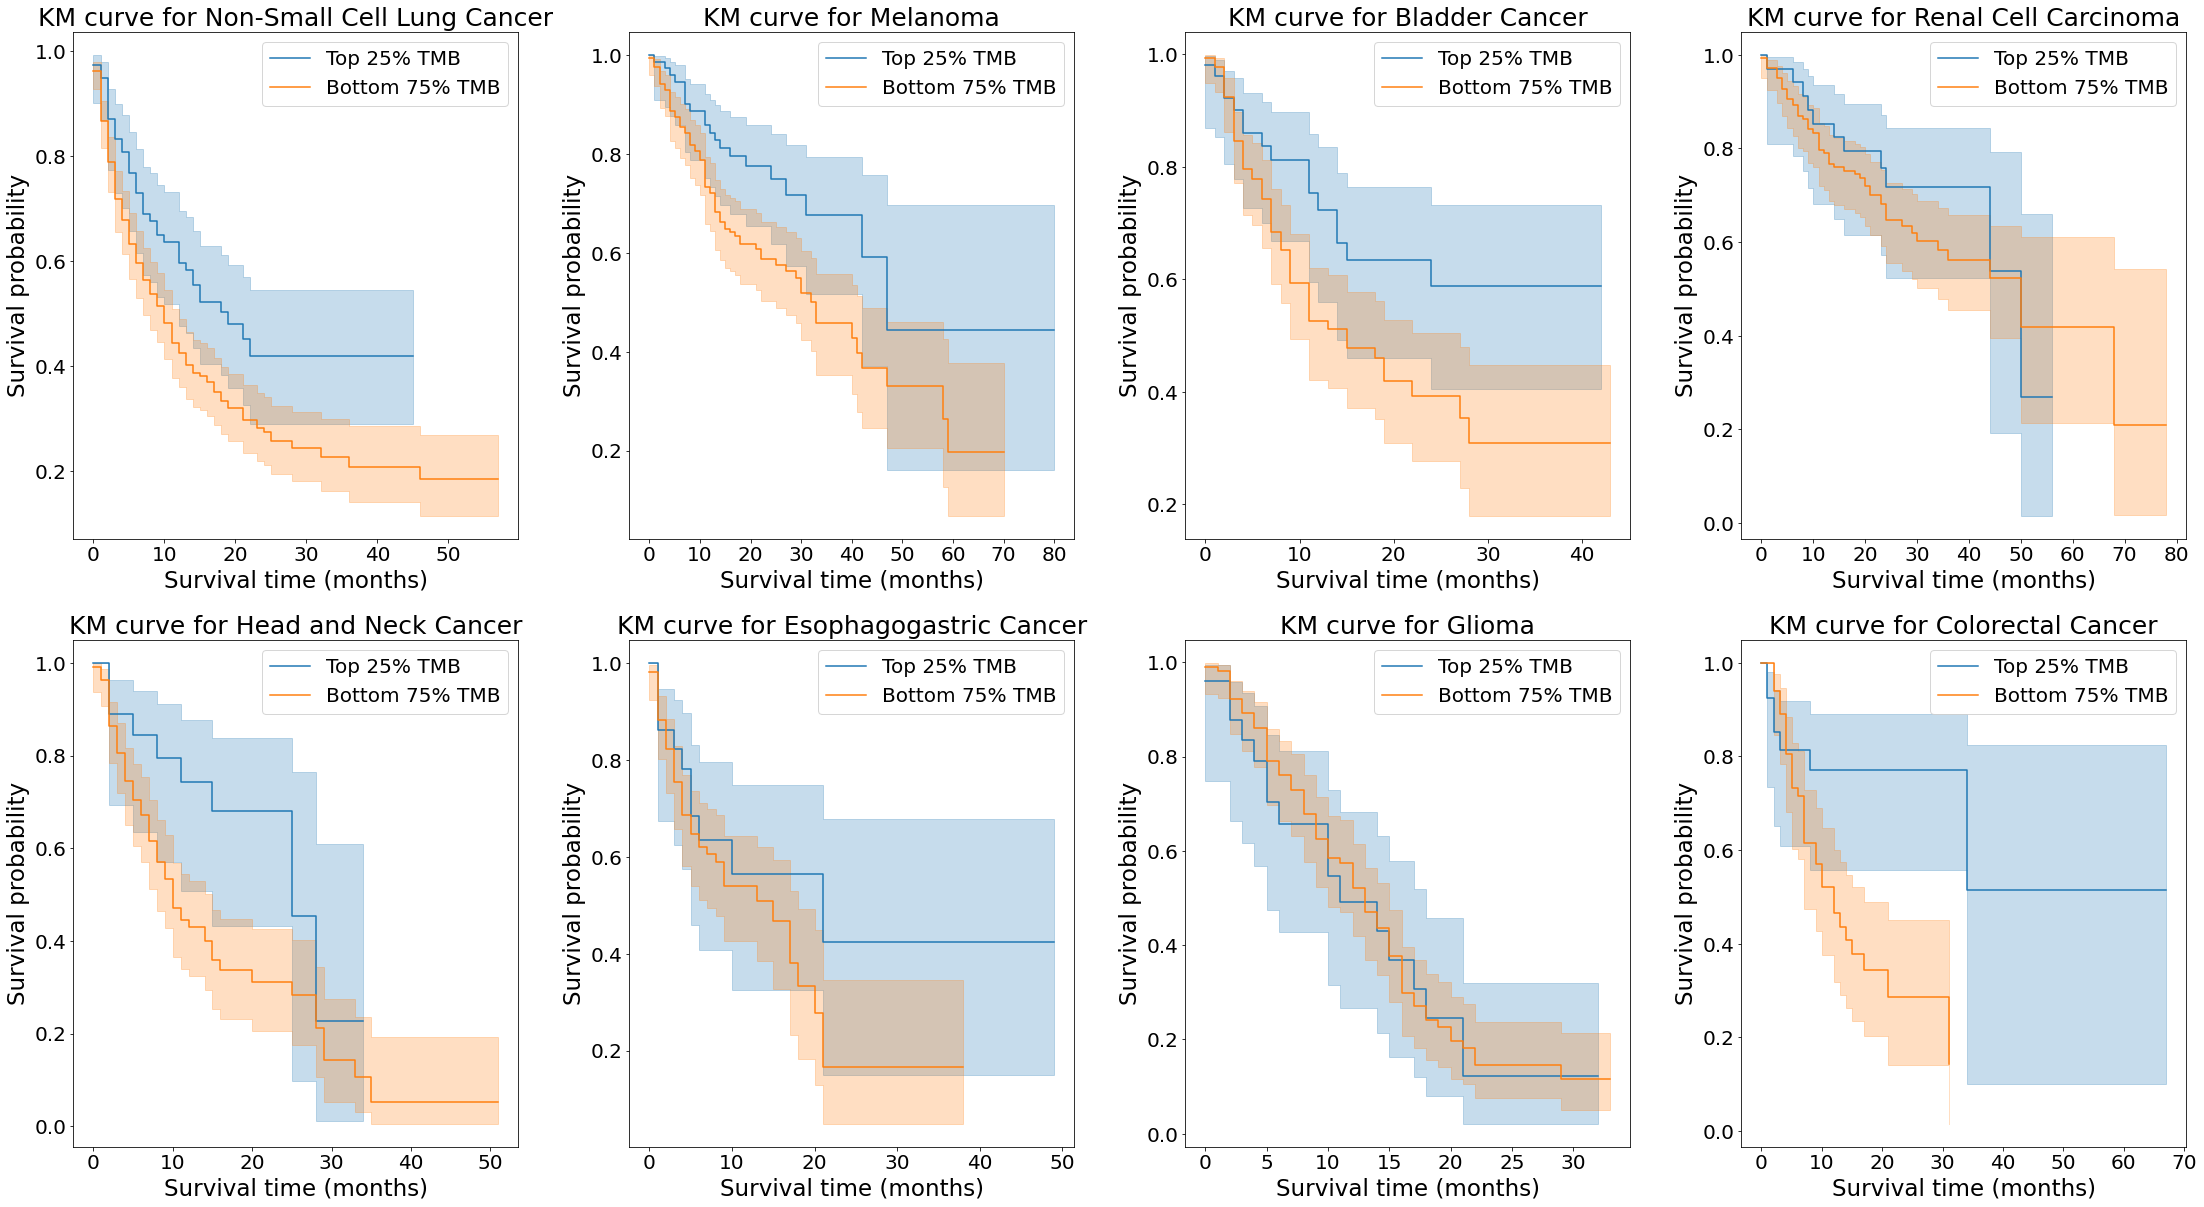

In [25]:
plt.subplots(2, 4, figsize=(32, 18))
plt.tight_layout(pad=8)

count = 0 
for i in Cancer_type_100:
  plt.subplot(241+count) 
  TMB_type = TMB_Survival[TMB_Survival['Cancer_Type'] == i]


  TMB_cutoff = TMB_type.TMB.describe()['75%']
  TMB_type_25 =  TMB_type[TMB_type['TMB']>TMB_cutoff]
  TMB_type_75 =  TMB_type[TMB_type['TMB']<TMB_cutoff]

  top25 = KaplanMeierFitter() 
  top25.fit(TMB_type_25.Survival_Month, TMB_type_25.Survival_Status_0_1, label = 'Top 25% TMB')
  top25.plot()
  TMB_type_75 = TMB_Survival_bottom75[TMB_Survival_bottom75['Cancer_Type'] == i]
  top75 = KaplanMeierFitter() 
  top75.fit(TMB_type_75.Survival_Month, TMB_type_75.Survival_Status_0_1, label = 'Bottom 75% TMB')
  top75.plot()
  plt.xlabel("Survival time (months)", fontsize=23)
  plt.ylabel("Survival probability", fontsize=23)
  plt.title("KM curve for " + i, fontsize=25)
  plt.rc('legend', fontsize=20) 
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  count = count + 1


In [26]:
for i in Cancer_type_100: 
  TMB_type = TMB_Survival[TMB_Survival['Cancer_Type'] == i]
  def Convert_TMB_Status(row):
    if row.TMB >= TMB_type.TMB.describe()['75%']:
      return 1
    else:
      return 0

  log_rank = pairwise_logrank_test(TMB_type.Survival_Month, TMB_type.apply(Convert_TMB_Status, axis='columns'), TMB_type.Survival_Status_0_1)
  print(log_rank.summary)


     test_statistic         p  -log2(p)
0 1        8.298052  0.003969  7.977095
     test_statistic         p  -log2(p)
0 1        3.454976  0.063062  3.987094
     test_statistic         p  -log2(p)
0 1        5.840711  0.015659  5.996818
     test_statistic         p  -log2(p)
0 1        0.449682  0.502486  0.992844
     test_statistic         p  -log2(p)
0 1         3.77268  0.052096  4.262681
     test_statistic         p  -log2(p)
0 1        1.048956  0.305748  1.709587
     test_statistic         p  -log2(p)
0 1        0.852813  0.355758  1.491032
     test_statistic         p  -log2(p)
0 1        5.642651  0.017529  5.834138


In [27]:
  log_rank.summary

,,test_statistic,p,-log2(p)
0,1,5.642651,0.017529,5.834138


In [28]:
TMB_Survival[TMB_Survival['Cancer_Type'] == Cancer_type_100[3]]

,TMB,Cancer_Type,Survival_Status_0_1,Survival_Month,TMB_Status
53,5.545777,Renal Cell Carcinoma,0,24,0
91,4.436621,Renal Cell Carcinoma,0,23,0
131,1.109155,Renal Cell Carcinoma,1,0,0
168,3.327466,Renal Cell Carcinoma,0,39,0
170,4.436621,Renal Cell Carcinoma,0,16,0
...,...,...,...,...,...
1272,4.323490,Renal Cell Carcinoma,1,1,0
1273,2.594094,Renal Cell Carcinoma,0,18,0
1308,1.729396,Renal Cell Carcinoma,0,18,0
1316,0.864698,Renal Cell Carcinoma,0,13,0


From the analysis above, it shows TMB works well in predicting clinical outcome except renal cell carcinoma and Glioma. For the modeling below, we will not considering this two cancer types. 

### __Estimate TMB from clinical factors using Regression models__
We attempted to estimate TMB from cinical factors using MLP regression model but errors are large as expected with limited number of clinical factors 


In [29]:
# Remove data from Renal Cell Caecinoma and Glioma because TMB is not a good biomarker for these two types of cancer 
Cancer_type_100 = Cancer_type[:8].index.tolist()
Cancer_type_100.remove("Renal Cell Carcinoma")
Cancer_type_100.remove("Glioma")
Clinical = Clinical[Clinical["Cancer_Type"].isin(Cancer_type_100)]

def convert_CancerType(row):
  count = 0
  for i in Cancer_type_100:
    count = count + 1
    if row.Cancer_Type == i:
      return count
Clinical['Cancer_Type_Coded'] = Clinical.apply(convert_CancerType, axis='columns')
Clinical['Cancer_Type_Coded'] = Clinical['Cancer_Type_Coded'].astype('int32')
Clinical


<ipython-input-29-92d705dfea86>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clinical['Cancer_Type_Coded'] = Clinical.apply(convert_CancerType, axis='columns')
<ipython-input-29-92d705dfea86>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clinical['Cancer_Type_Coded'] = Clinical['Cancer_Type_Coded'].astype('int32')


,ID,Age_Days_Sequencing,Age_Diagnosis_Years,Cancer_Type,Drug_Type,Mutation_Count,Survival_Month,Survival_Status,Primary_Tumor_Site,Sample_coverage,Sample_Type,Sex,Somatic_Status,TMB,Tumor_Purity,Survival_Status_0_1,Gender_binary,Cancer_Type_Coded
1,P-0000062,80.0,>71,Esophagogastric Cancer,PD-1/PDL-1,6.0,1,1:DECEASED,Esophagus,1176,Primary,Male,Matched,6.654932,30.0,1,0,5
2,P-0000063,62.0,61-70,Bladder Cancer,PD-1/PDL-1,13.0,42,0:LIVING,Bladder,900,Primary,Male,Matched,15.528174,70.0,0,0,3
3,P-0000071,66.0,61-70,Bladder Cancer,PD-1/PDL-1,10.0,43,0:LIVING,Bladder,795,Primary,Male,Matched,9.982398,30.0,0,0,3
5,P-0000088,63.0,61-70,Bladder Cancer,PD-1/PDL-1,12.0,12,1:DECEASED,Bladder,783,Metastasis,Male,Matched,12.200708,60.0,1,0,3
6,P-0000103,47.0,31-50,Esophagogastric Cancer,Combo,6.0,18,1:DECEASED,Esophagus,997,Metastasis,Male,Matched,6.654932,50.0,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1655,P-0026723,58.0,50-60,Bladder Cancer,PD-1/PDL-1,9.0,1,0:LIVING,Bladder,750,Primary,Male,Matched,6.917585,50.0,0,0,3
1656,P-0026892,89.0,>71,Bladder Cancer,PD-1/PDL-1,7.0,3,0:LIVING,Bladder,450,Metastasis,Male,Matched,6.052887,20.0,0,0,3
1657,P-0026970,62.0,61-70,Bladder Cancer,PD-1/PDL-1,30.0,4,0:LIVING,Bladder,676,Metastasis,Male,Matched,25.940943,40.0,0,0,3
1658,P-0027031,32.0,31-50,Esophagogastric Cancer,PD-1/PDL-1,3.0,5,0:LIVING,Stomach,413,Metastasis,Female,Matched,2.594094,30.0,0,1,5


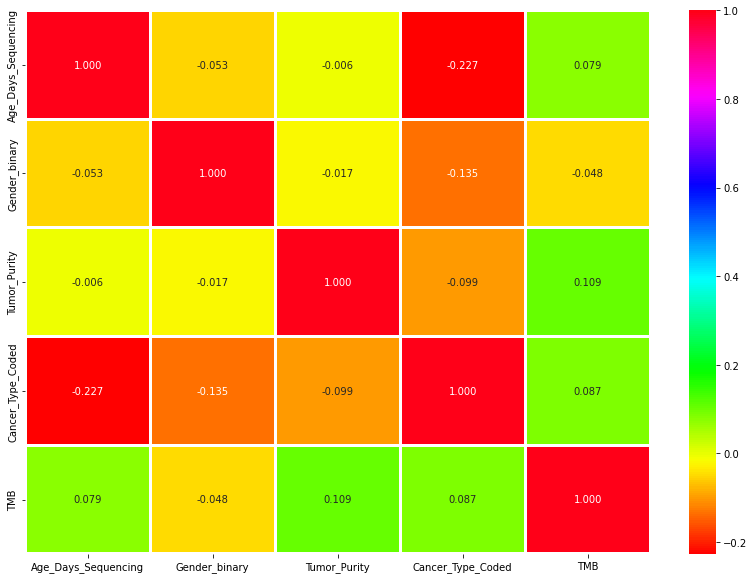

In [30]:
TMB_Clinical = Clinical[["Age_Days_Sequencing","Gender_binary","Tumor_Purity","Cancer_Type_Coded","TMB"]]
plt.figure(figsize=(14,10))
sns.heatmap(TMB_Clinical.corr(),annot=True,cmap='hsv',fmt='.3f',linewidths=2)
plt.show()

__MLP Regression__

estimating TMB from clinical data 

In [31]:
# Split the data into training and test set
from sklearn.model_selection import train_test_split
y = TMB_Clinical.TMB.to_numpy()
X = TMB_Clinical.iloc[:,:4].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.2)


In [32]:
sc = StandardScaler()
scaler = sc.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
mlp_reg = MLPRegressor(hidden_layer_sizes=(20,10),
                       max_iter = 300,activation = 'relu',
                       solver = 'adam')

mlp_reg.fit(X_train_scaled, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(20, 10), max_iter=300)

In [34]:
y_pred = mlp_reg.predict(X_test_scaled)
df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_temp.head()

,Actual,Predicted
0,4.893598,17.088949
1,6.917585,13.138452
2,45.475367,12.139999
3,3.327466,11.455297
4,6.052887,16.957565


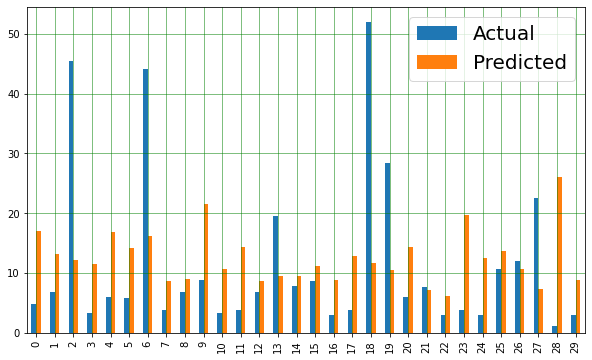

In [35]:
df_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [36]:
print('Mean Absolute Error:')
print(metrics.mean_absolute_error(y_test, y_pred))   
print(" ")
print('Mean Squared Error:')
print(metrics.mean_squared_error(y_test, y_pred))  
print(" ")
print('Root Mean Squared Error:')
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error:
11.340349822493598
 
Mean Squared Error:
318.17918252187445
 
Root Mean Squared Error:
17.837577821046064
